<a href="https://colab.research.google.com/github/miwa223/house_price_prediction/blob/master/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [2]:
%cd "/content/drive/My Drive/data/"

/content/drive/My Drive/data


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train_len = train_data.shape[0]
train_data.columns

Index(['id', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', 'y'],
      dtype='object')

In [5]:
train_data.shape, test_data.shape

((356344, 28), (34844, 27))

In [6]:
train_data = pd.concat([train_data, test_data]).reset_index(drop=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391188 entries, 0 to 391187
Data columns (total 28 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          391188 non-null  int64  
 1   種類          391188 non-null  object 
 2   地域          214339 non-null  object 
 3   市区町村コード     391188 non-null  int64  
 4   都道府県名       391188 non-null  object 
 5   市区町村名       391188 non-null  object 
 6   地区名         390942 non-null  object 
 7   最寄駅：名称      389500 non-null  object 
 8   最寄駅：距離（分）   380898 non-null  object 
 9   間取り         170427 non-null  object 
 10  面積（㎡）       391188 non-null  object 
 11  土地の形状       213940 non-null  object 
 12  間口          196158 non-null  object 
 13  延床面積（㎡）     131541 non-null  object 
 14  建築年         301683 non-null  object 
 15  建物の構造       305722 non-null  object 
 16  用途          297993 non-null  object 
 17  今後の利用目的     143467 non-null  object 
 18  前面道路：方位     213915 non-null  object 
 19  前面

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


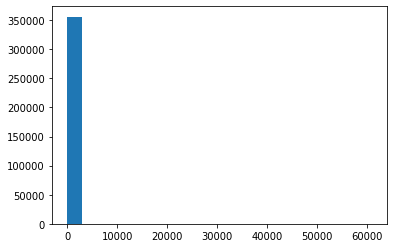

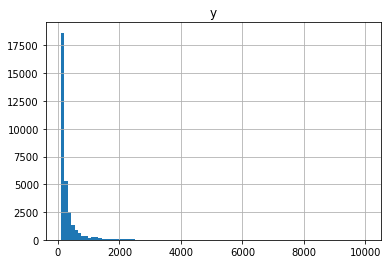

In [7]:
plt.hist(train_data['y'], bins=20);
train_data[['y']].hist(range=(100,10000), bins=90);

In [0]:
pd.set_option('display.max_rows', 100)

#前処理


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13217 missing from current font.
  font.set_

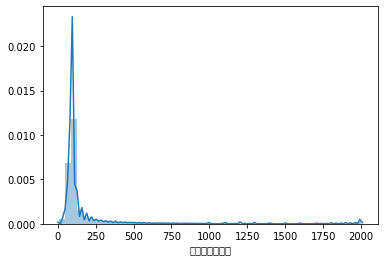

In [11]:
train_data['延床面積（㎡）'] = train_data['延床面積（㎡）'].replace('2000㎡以上', '2000')
train_data['延床面積（㎡）'] = train_data['延床面積（㎡）'].replace('10m^2未満', '9')
sns.distplot(train_data['延床面積（㎡）'], bins=50);
train_data['延床面積（㎡）'] = train_data['延床面積（㎡）'].dropna().astype(int)
train_data['延床面積（㎡）'] = train_data['延床面積（㎡）'].fillna(train_data['延床面積（㎡）'].mean())

In [0]:
train_data['間口'] = train_data['間口'].replace('50.0m以上', '50').dropna().astype(float)
train_data['間口'] = train_data['間口'].fillna(train_data['間口'].mean())

In [0]:
train_data['面積（㎡）'] = train_data['面積（㎡）'].replace('2000㎡以上', '2000')
train_data['面積（㎡）'] = train_data['面積（㎡）'].replace('5000㎡以上', '5000').astype(int)

In [0]:
train_data['最寄駅：距離（分）'] = train_data['最寄駅：距離（分）'].replace('30分?60分','45')
train_data['最寄駅：距離（分）'] = train_data['最寄駅：距離（分）'].replace('1H?1H30','75')
train_data['最寄駅：距離（分）'] = train_data['最寄駅：距離（分）'].replace('1H30?2H','105')
train_data['最寄駅：距離（分）'] = train_data['最寄駅：距離（分）'].replace('2H?','120')
train_data['最寄駅：距離（分）'] = pd.to_numeric(train_data['最寄駅：距離（分）'], errors='coerce')
train_data['最寄駅：距離（分）'] = train_data['最寄駅：距離（分）'].fillna(train_data['最寄駅：距離（分）'].mean())

In [0]:
train_data['建築年'] = train_data['建築年'].dropna()
train_data['建築年'] = train_data['建築年'].str.replace('戦前','昭和20年')
train_data['年号'] = train_data['建築年'].str[:2]
train_data['和暦年数'] = train_data['建築年'].str[2:].str.strip('年').fillna(0).astype(int)
train_data.loc[train_data['年号']=='昭和','建築年(西暦)'] = train_data['和暦年数'] + 1925
train_data.loc[train_data['年号']=='平成','建築年(西暦)'] = train_data['和暦年数'] + 1988
train_data['建築年'] = train_data['建築年(西暦)'].fillna(train_data['建築年(西暦)'].mean())

In [0]:
train_data['容積率（％）'] = train_data['容積率（％）'].fillna(train_data['容積率（％）'].mean())
train_data['前面道路：幅員（ｍ）'] = train_data['前面道路：幅員（ｍ）'].fillna(train_data['前面道路：幅員（ｍ）'].mean())
train_data['建ぺい率（％）'] = train_data['建ぺい率（％）'].fillna(train_data['建ぺい率（％）'].mean())
train_data['地区名'] = train_data['地区名'].fillna(train_data['地区名'].mode()[0])
train_data['建物の構造'] = train_data['建物の構造'].fillna(train_data['建物の構造'].mode()[0])
train_data['都市計画'] = train_data['都市計画'].fillna(train_data['都市計画'].mode()[0])
train_data['改装'] = train_data['改装'].fillna('未改装')
train_data['地域'] = train_data['地域'].fillna('NONE')
train_data['用途'] = train_data['用途'].fillna('NONE')
train_data['間取り'] = train_data['間取り'].fillna('NONE')
train_data['土地の形状'] = train_data['土地の形状'].fillna('NONE')
train_data['最寄駅：名称'] = train_data['最寄駅：名称'].fillna('NONE')
train_data['今後の利用目的'] = train_data['今後の利用目的'].fillna('NONE')
train_data['前面道路：方位'] = train_data['前面道路：方位'].fillna('NONE')
train_data['前面道路：種類'] = train_data['前面道路：種類'].fillna('NONE')
train_data['取引の事情等'] = train_data['取引の事情等'].fillna('NONE')

In [17]:
l = ['最寄駅：距離（分）','容積率（％）','建築年','建ぺい率（％）','前面道路：幅員（ｍ）', '延床面積（㎡）', '面積（㎡）', '間口']
for name in l:
    mean = np.nanmean(train_data[name], axis=0)
    std = np.nanstd(train_data[name], axis=0)
    train_data[name] = (train_data[name] - mean)/std
train_data.describe()

,id,市区町村コード,最寄駅：距離（分）,面積（㎡）,間口,延床面積（㎡）,建築年,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）,y,和暦年数,建築年(西暦)
count,391188.000000,391188.000000,3.911880e+05,3.911880e+05,3.911880e+05,3.911880e+05,3.911880e+05,3.911880e+05,3.911880e+05,3.911880e+05,356344.000000,391188.000000,301683.000000
mean,163854.133895,13139.983445,-1.369162e-13,-9.930281e-15,1.004992e-14,1.959707e-14,2.707244e-14,-1.993676e-14,3.409330e-13,-1.661080e-13,65.434766,21.016258,1997.799684
std,108373.967331,46.231578,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,315.011339,19.584387,14.043494
min,1.000000,13101.000000,-1.112769e+00,-5.256174e-01,-1.966281e+00,-1.051748e+00,-4.281286e+00,-1.466856e+00,-2.460636e+00,-1.356476e+00,0.000500,0.000000,1945.000000
25%,62953.750000,13110.000000,-5.939510e-01,-3.303236e-01,-3.494697e-01,-3.388183e-01,-4.702699e-01,-3.775459e-01,-1.595784e-01,-7.251427e-01,21.000000,3.000000,1988.000000
50%,160750.500000,13117.000000,-1.788962e-01,-2.326766e-01,-6.802184e-15,0.000000e+00,1.843669e-14,2.753659e-14,-1.595784e-01,-4.094762e-01,35.000000,18.000000,2001.000000
75%,258547.250000,13201.000000,2.361586e-01,-1.297106e-02,-6.802184e-15,0.000000e+00,7.460117e-01,2.753659e-14,1.374460e+00,2.218567e-01,53.000000,28.000000,2009.000000
max,356344.000000,13421.000000,1.133887e+01,2.383729e+01,8.585538e+00,1.173602e+01,1.719037e+00,2.339176e+01,1.374460e+00,6.535186e+00,61000.000000,64.000000,2019.000000


In [0]:
#使用する説明変数・目的変数を代入
model_input = train_data[['種類','地域','市区町村コード','最寄駅：名称','最寄駅：距離（分）','間取り','面積（㎡）','土地の形状','容積率（％）',
                          '建築年','建物の構造','用途','都市計画','建ぺい率（％）','間口','今後の利用目的','前面道路：方位','前面道路：種類',
                          '前面道路：幅員（ｍ）','延床面積（㎡）','改装','取引の事情等','取引時点','y']]

#目的変数と説明変数を代入
X = model_input.drop("y", 1).dropna(how='any', axis=1) 
y = model_input['y']

In [19]:
X.nunique()

種類              5
地域              5
市区町村コード        59
最寄駅：名称        657
最寄駅：距離（分）      35
間取り            49
面積（㎡）         156
土地の形状          10
容積率（％）         18
建築年            76
建物の構造          26
用途            206
都市計画           16
建ぺい率（％）         7
間口            477
今後の利用目的         7
前面道路：方位        10
前面道路：種類        15
前面道路：幅員（ｍ）    381
延床面積（㎡）       131
改装              2
取引の事情等         26
取引時点           55
dtype: int64

In [20]:
X.isna().sum()

種類            0
地域            0
市区町村コード       0
最寄駅：名称        0
最寄駅：距離（分）     0
間取り           0
面積（㎡）         0
土地の形状         0
容積率（％）        0
建築年           0
建物の構造         0
用途            0
都市計画          0
建ぺい率（％）       0
間口            0
今後の利用目的       0
前面道路：方位       0
前面道路：種類       0
前面道路：幅員（ｍ）    0
延床面積（㎡）       0
改装            0
取引の事情等        0
取引時点          0
dtype: int64

In [21]:
train_data.corr()

,id,市区町村コード,最寄駅：距離（分）,面積（㎡）,間口,延床面積（㎡）,建築年,前面道路：幅員（ｍ）,建ぺい率（％）,容積率（％）,y,和暦年数,建築年(西暦)
id,1.000000,0.541627,0.295077,0.128778,0.053867,-0.086215,-0.009585,-0.034626,-0.343889,-0.392251,-0.049534,-0.078805,-0.010955
市区町村コード,0.541627,1.000000,0.382554,0.205880,0.124719,-0.091553,0.083256,-0.036720,-0.457177,-0.447083,-0.050684,-0.073859,0.099967
最寄駅：距離（分）,0.295077,0.382554,1.000000,0.137506,0.066616,-0.097435,0.075202,-0.038464,-0.419722,-0.392834,-0.041303,-0.047146,0.088958
面積（㎡）,0.128778,0.205880,0.137506,1.000000,0.588286,0.329579,-0.045534,0.147521,-0.162773,-0.161742,0.328973,-0.124690,-0.084897
間口,0.053867,0.124719,0.066616,0.588286,1.000000,0.348903,-0.111694,0.181524,-0.026299,-0.007221,0.265654,-0.054446,-0.171743
延床面積（㎡）,-0.086215,-0.091553,-0.097435,0.329579,0.348903,1.000000,-0.141246,0.322081,0.172623,0.195348,0.401985,0.031619,-0.142767
建築年,-0.009585,0.083256,0.075202,-0.045534,-0.111694,-0.141246,1.000000,-0.076528,-0.122301,-0.116599,-0.019875,-0.431466,1.000000
前面道路：幅員（ｍ）,-0.034626,-0.036720,-0.038464,0.147521,0.181524,0.322081,-0.076528,1.000000,0.204745,0.224850,0.205698,0.012300,-0.099172
建ぺい率（％）,-0.343889,-0.457177,-0.419722,-0.162773,-0.026299,0.172623,-0.122301,0.204745,1.000000,0.827252,0.039418,0.100276,-0.140217
容積率（％）,-0.392251,-0.447083,-0.392834,-0.161742,-0.007221,0.195348,-0.116599,0.224850,0.827252,1.000000,0.066610,0.127459,-0.129076


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 21306 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30010 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26449 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0,

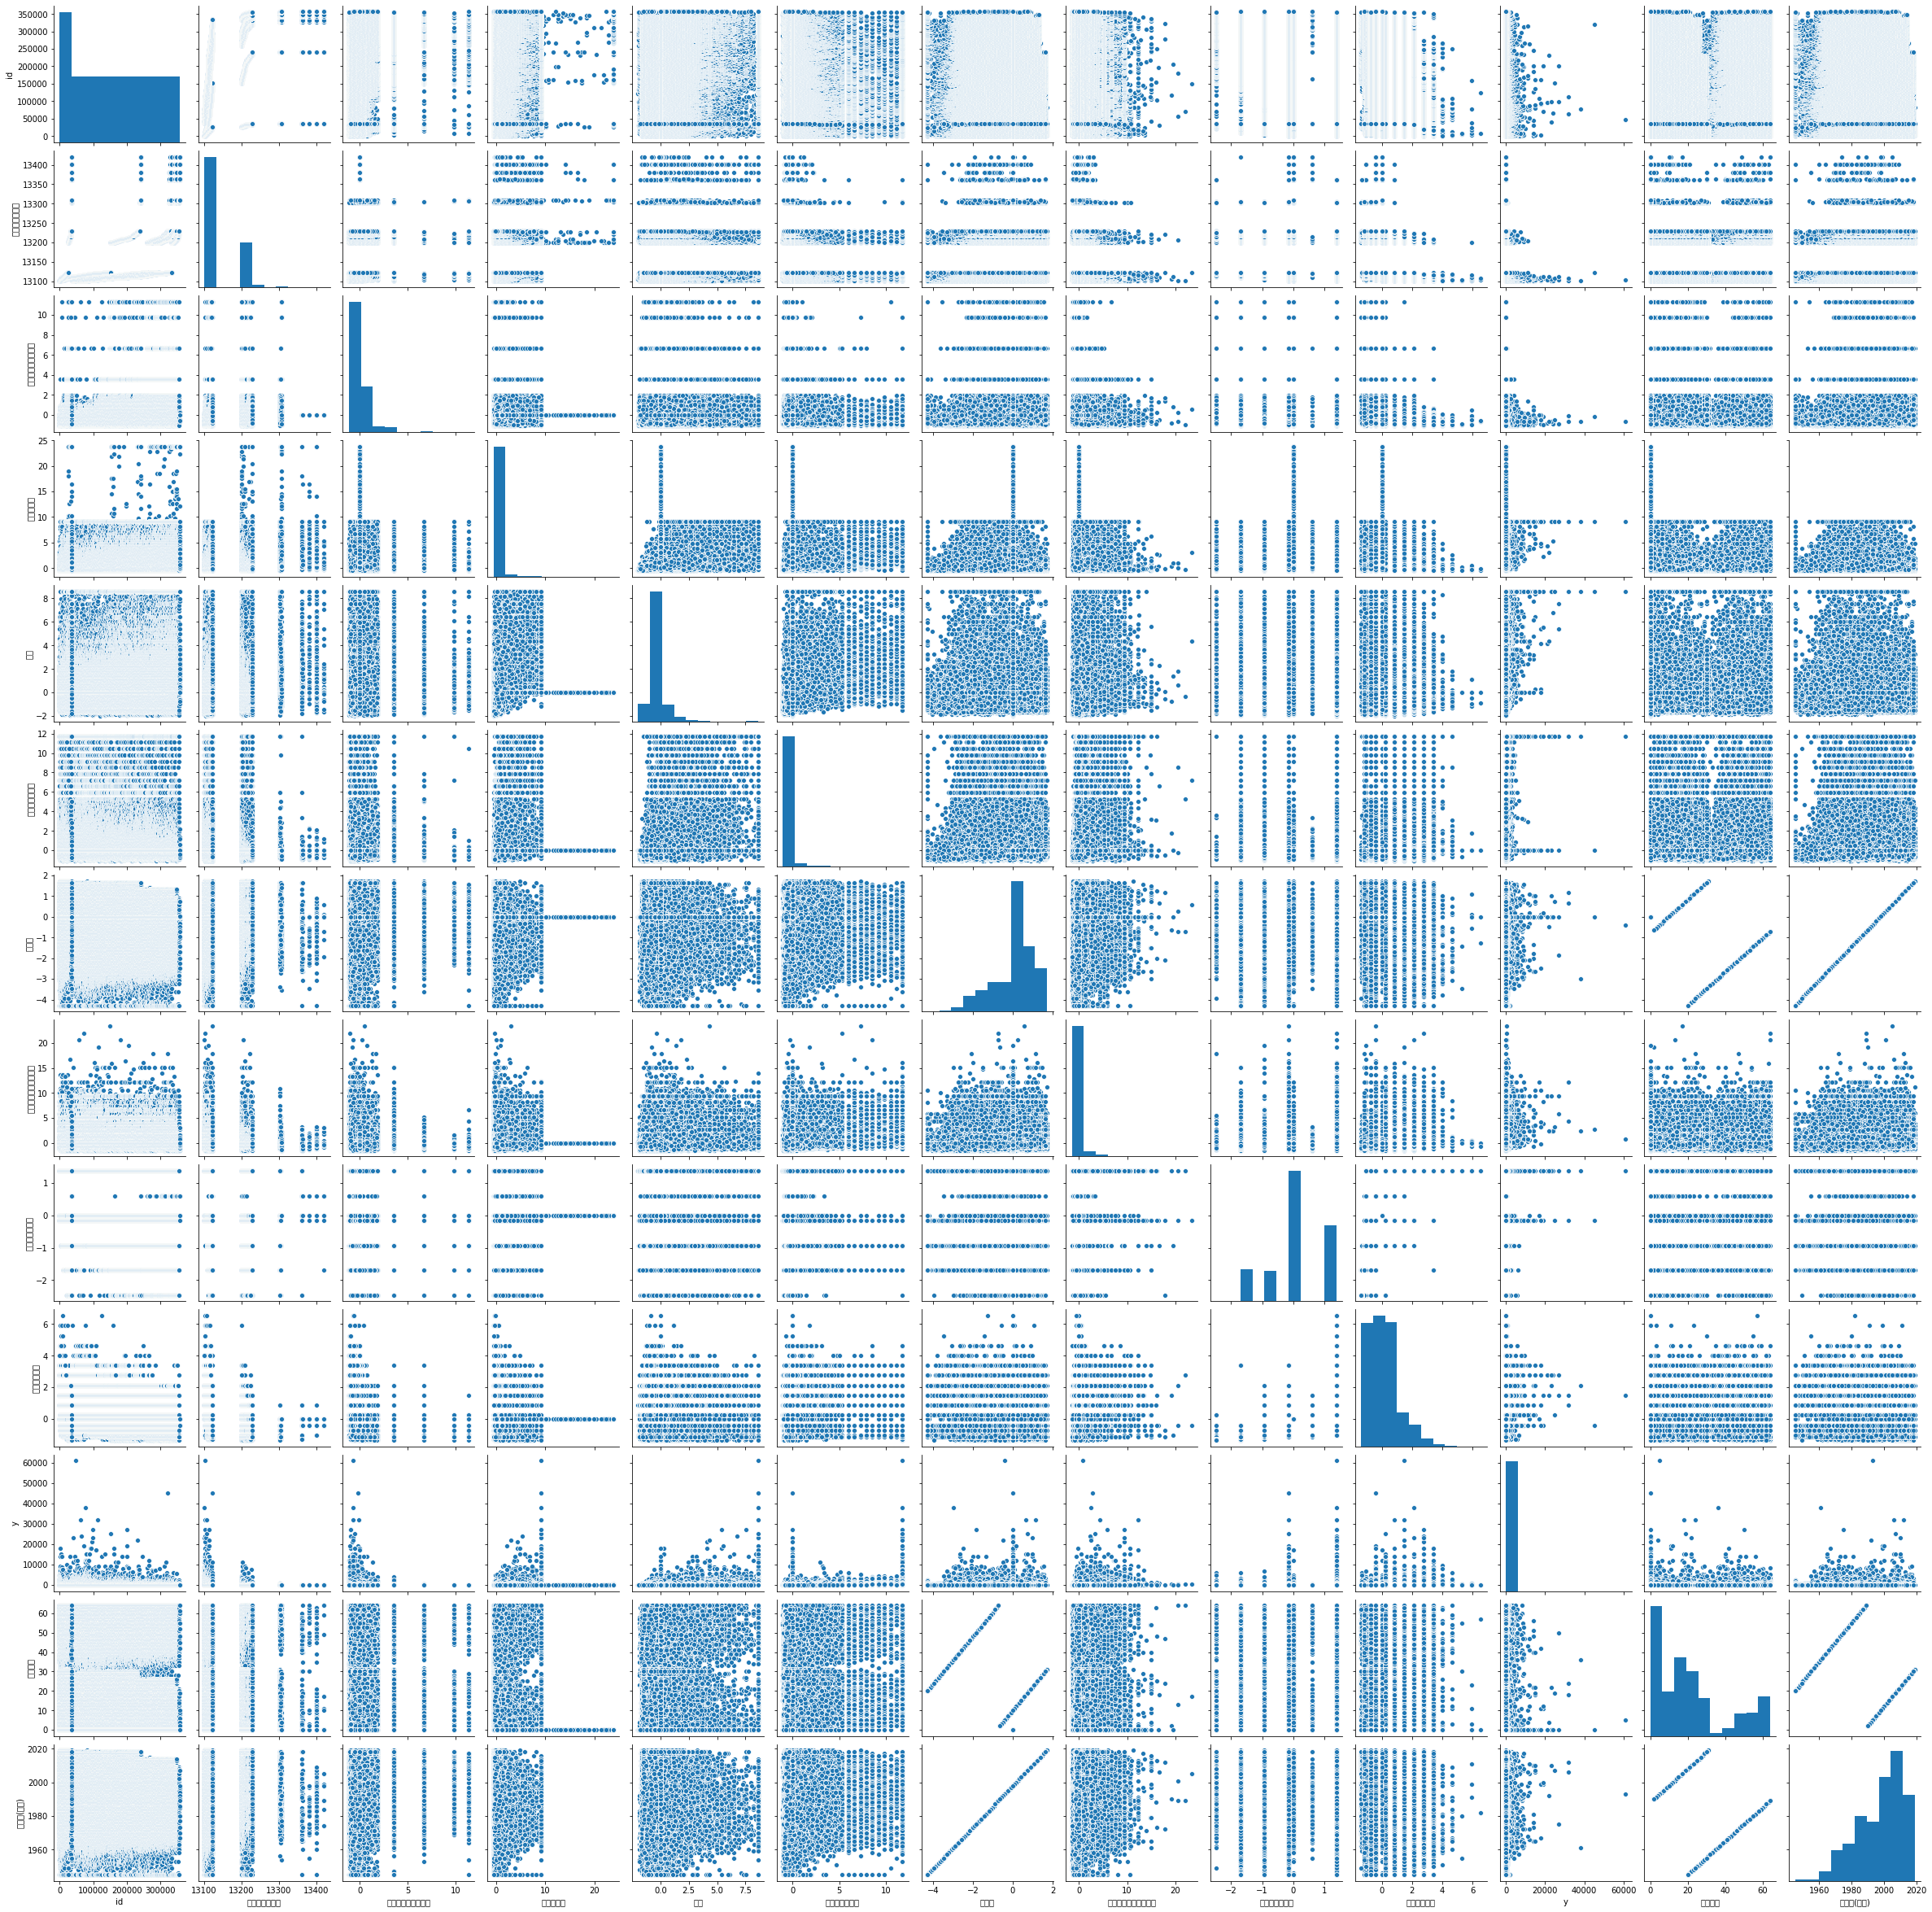

In [22]:
sns.pairplot(train_data)

In [0]:
import re
X = X.drop("間口", 1)
X = X.drop("建ぺい率（％）", 1)
X = X.drop("前面道路：種類", 1)
X = X.drop("容積率（％）", 1)
#X["面積（㎡）"] = X["面積（㎡）"].apply(lambda x: re.findall("\d+", x)[0] if x else 0).astype(int)

In [24]:
#one-hot表現へ変換
X = pd.get_dummies(X, drop_first=True)
X

,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,前面道路：幅員（ｍ）,延床面積（㎡）,種類_宅地(土地),種類_宅地(土地と建物),種類_林地,種類_農地,地域_住宅地,地域_商業地,地域_宅地見込地,地域_工業地,最寄駅：名称_お台場海浜公園,最寄駅：名称_お花茶屋,最寄駅：名称_こどもの国(神奈川),最寄駅：名称_すずかけ台,最寄駅：名称_つくし野,最寄駅：名称_つつじケ丘,最寄駅：名称_とうきょうスカイツリー,最寄駅：名称_ときわ台(東京),最寄駅：名称_ひばりケ丘(東京),最寄駅：名称_めじろ台,最寄駅：名称_一之江,最寄駅：名称_一橋学園,最寄駅：名称_万願寺,最寄駅：名称_三ノ輪,最寄駅：名称_三ノ輪橋,最寄駅：名称_三河島,最寄駅：名称_三田(東京),最寄駅：名称_三越前,最寄駅：名称_三軒茶屋,最寄駅：名称_三鷹,最寄駅：名称_三鷹台,最寄駅：名称_上中里,最寄駅：名称_上井草,最寄駅：名称_上北台,最寄駅：名称_上北沢,最寄駅：名称_上板橋,...,取引時点_2009年第２四半期,取引時点_2009年第３四半期,取引時点_2009年第４四半期,取引時点_2010年第１四半期,取引時点_2010年第２四半期,取引時点_2010年第３四半期,取引時点_2010年第４四半期,取引時点_2011年第１四半期,取引時点_2011年第２四半期,取引時点_2011年第３四半期,取引時点_2011年第４四半期,取引時点_2012年第１四半期,取引時点_2012年第２四半期,取引時点_2012年第３四半期,取引時点_2012年第４四半期,取引時点_2013年第１四半期,取引時点_2013年第２四半期,取引時点_2013年第３四半期,取引時点_2013年第４四半期,取引時点_2014年第１四半期,取引時点_2014年第２四半期,取引時点_2014年第３四半期,取引時点_2014年第４四半期,取引時点_2015年第１四半期,取引時点_2015年第２四半期,取引時点_2015年第３四半期,取引時点_2015年第４四半期,取引時点_2016年第１四半期,取引時点_2016年第２四半期,取引時点_2016年第３四半期,取引時点_2016年第４四半期,取引時点_2017年第１四半期,取引時点_2017年第２四半期,取引時点_2017年第３四半期,取引時点_2017年第４四半期,取引時点_2018年第１四半期,取引時点_2018年第２四半期,取引時点_2018年第３四半期,取引時点_2018年第４四半期,取引時点_2019年第１四半期
0,13101,-1.009006,-0.305912,-1.118953e+00,2.753659e-14,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,13101,-0.593951,-0.476794,4.216699e-01,2.753659e-14,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,13101,-0.801478,-0.354735,1.151439e+00,2.753659e-14,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,13101,-0.593951,-0.476794,4.216699e-01,2.753659e-14,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,13101,-0.801478,-0.183853,-9.567825e-01,4.883160e-01,1.009967,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391183,13401,0.000000,3.526730,1.843669e-14,-1.444252e-02,-0.724185,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
391184,13401,0.000000,1.232027,1.843669e-14,-4.892700e-01,0.000000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
391185,13401,0.000000,1.964379,1.843669e-14,-3.496149e-01,0.000000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
391186,13421,0.000000,1.280851,1.843669e-14,-4.892700e-01,0.000000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

#LightGBM


In [0]:
(Xtrain, Xtest, ytrain, ytest) = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

lgb_train = lgb.Dataset(Xtrain, label=ytrain)
lgb_eval = lgb.Dataset(Xtest, label=ytest, reference=lgb_train)

In [0]:
param = {'objective' : 'regression',
          'metric': 'rmse',
          'max_depth' : 7,
         'nfold' : 5}
bst = lgb.train(param, lgb_train, num_boost_round=100000, early_stopping_rounds=10000, verbose_eval=500, valid_sets=lgb_eval)
#valid_0's rmse: 129.299 (16)
#valid_0's rmse: 126.404 (17)

Training until validation scores don't improve for 10000 rounds.
[500]	valid_0's rmse: 141.658
[1000]	valid_0's rmse: 145.068
[1500]	valid_0's rmse: 148.161
[2000]	valid_0's rmse: 149.652
[2500]	valid_0's rmse: 150.743
[3000]	valid_0's rmse: 151.621
[3500]	valid_0's rmse: 152.154
[4000]	valid_0's rmse: 152.711
[4500]	valid_0's rmse: 152.532
[5000]	valid_0's rmse: 152.989
[5500]	valid_0's rmse: 153.372
[6000]	valid_0's rmse: 153.958
[6500]	valid_0's rmse: 154.291
[7000]	valid_0's rmse: 154.539
[7500]	valid_0's rmse: 154.709
[8000]	valid_0's rmse: 154.674
[8500]	valid_0's rmse: 154.984
[9000]	valid_0's rmse: 155.018
[9500]	valid_0's rmse: 155.142
[10000]	valid_0's rmse: 155.426
Early stopping, best iteration is:
[164]	valid_0's rmse: 126.404


In [0]:
ypred = bst.predict(X_test, num_iteration=bst.best_iteration)
ypred

In [0]:
submit_df = pd.DataFrame({'y': ypred})
submit_df.index.name = 'id'
submit_df.index = submit_df.index + 1
submit_df.to_csv('submission.csv')

In [0]:
!head submission.csv

id,y
1,18.434893190175625
2,13.33749316431684
3,132.2686747131353
4,17.293689001300837
5,51.89798100787634
6,21.41767682393149
7,69.45436210319468
8,29.73552727370822
9,60.827402966459665


#XGBoost

In [0]:
%%time
mod = xgb.XGBRegressor()
mod.fit(X_train, y_train)

[04:24:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_train_pred = mod.predict(X_train)
y_test_pred = mod.predict(X_test)

In [0]:
#RMSE
y_true = y_train
print(np.sqrt(mean_squared_error(y_true, y_train_pred)))

#179.6746269461159 params: default

179.6746269461159


In [0]:
submit_df = pd.DataFrame({'y': y_test_pred})
submit_df.index.name = 'id'
submit_df.index = submit_df.index + 1
submit_df.to_csv('submission.csv')

In [0]:
!head submission.csv

id,y
1,28.326355
2,28.326355
3,161.38408
4,28.326355
5,51.006256
6,28.326355
7,62.20146
8,37.23714
9,57.626347


#GridSearch in XGBoost


In [0]:
%%time
params = {'learning_rate': [0.05, 0.1]}
mod = xgb.XGBRegressor(max_depth=5, colsample_bytree=0.5, subsample=0.95, random_state=0)

cv = GridSearchCV(mod, params, cv = 3, scoring= 'neg_root_mean_squared_error', n_jobs =1)
cv.fit(X_train, y_train)

[06:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:47:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 59min 25s, sys: 1.25 s, total: 59min 26s
Wall time: 59min 27s


In [0]:
y_train_pred = cv.predict(X_train)
y_test_pred = cv.predict(X_test)

In [0]:
cv.best_params_

{'learning_rate': 0.1}

In [0]:
#RMSE
y_true = y_train
print(np.sqrt(mean_squared_error(y_true, y_train_pred)))

#129.59496919959915 (14)
#127.19196029388782 (15)

127.19196029388782


In [0]:
submit_df = pd.DataFrame({'y': y_test_pred})
submit_df.index.name = 'id'
submit_df.index = submit_df.index + 1
submit_df.to_csv('submission.csv')

In [0]:
!head submission.csv

#RandomForest

In [0]:
%%time
model = RandomForestRegressor(n_estimators=20, random_state=0)
model = model.fit(X_train, y_train)

CPU times: user 11min 3s, sys: 1.18 s, total: 11min 4s
Wall time: 11min 7s


#GridSearch in RandomForest

In [0]:
%%time
gscv = GridSearchCV(RandomForestRegressor(n_estimators=10), 
                   {'max_depth':[10, None], 'min_samples_leaf':[2],
                    'random_state':[0]}, scoring='r2', cv=3)
gscv = gscv.fit(X_train, y_train)

CPU times: user 25min 54s, sys: 1.35 s, total: 25min 55s
Wall time: 25min 59s


In [0]:
gscv.score(X_train, y_train)
#0.43636603383058803 random forest with gridsearch
#0.5988877395810059
#0.711004593196928
#0.7904398793609035

0.7904398793609035

In [0]:
model.feature_importances_

array([8.26625715e-02, 2.78572627e-02, 1.13805890e-01, ...,
       1.30864643e-11, 1.57151649e-06, 4.54023231e-09])

In [0]:
gscv.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'random_state': 0}

In [0]:
#RMSE
y_true = y_train
y_pred = gscv.predict(X_train)
print(np.sqrt(mean_squared_error(y_true, y_pred)))

#236.49619409498007 random forest with gridsearch
#199.50718735074088
#169.34448112160334
#144.20486007054598

144.20486007054598


#LinearRegression

In [0]:
%%time
model = LR()
model = model.fit(X_train, y_train)

CPU times: user 3min 2s, sys: 12.1 s, total: 3min 14s
Wall time: 1min 44s


In [0]:
#各説明変数の係数
coeff = pd.DataFrame(X_train.columns)
coeff.columns = ['説明変数']
coeff['係数推定'] = model.coef_
print(coeff)

In [0]:
#回帰モデルの切片
model.intercept_
#58.86466422497909
#4959.459967998793 (ほぼ全コラム使って線形回帰したときの結果)

In [0]:
#決定係数
model.score(X_train,y_train)

#0.312906449494207
#0.16304178133908476
#0.2209040221102827
#0.25250753942598014 add dropped columns except 市区町村名
#0.23800817635780921 remove outliers over 83
#0.22777359472289327
#0.2510636080123616
#0.27412754916212834(ほぼ全部のデータ使って線形回帰したときの結果)
#0.3087230557273756 added 延床面積 without 地区名
#0.9131536629725254 random forest
#0.8059683415298241
#0.9200251712759521 set n_estimator=100
#0.9138989240234229 removed '建ぺい率'
#0.9117378979563754 removed '建築年（西暦）'
#0.9145776366842079 changed 'FILL' to mode()[0] (8)
#0.9123305975541516 changed mode() based on memo (including 間口)
#0.9123544094947007 removed 間口
#0.9132373222514765 removed '前面道路：種類'
#0.9125859491875066 removed 取引の事情等 (10)
#0.9133406544239986 removed 土地の形状

0.9118245767649782

In [0]:
# RMSE
y_true = y_train
y_pred = model.predict(X_train)
print(np.sqrt(mean_squared_error(y_true, y_pred)))

#288.18904426379794
#287.2087423433987
#278.04882152292515
#272.3510072981888
#276.8202786032452
#272.6139306490177 
#268.3834519525306 (ほぼ全部のデータ使って線形回帰したときの結果)
#261.9097184790075 added 延床面積 without 地区名
#92.83277449023637 random forest
#138.7592281665372
#89.08451848124638 set n_estimator=100
#92.43359981804907 removed '建ぺい率' (5)
#93.58639336444281 removed '建築年（西暦）' (7)
#92.0685638639834 changed 'FILL' to mode()[0] 4/19 (8)
#93.27163736260736 changed mode() based on memo (including 間口)
#93.2589697188647 removed 間口 (9)
#92.78805070295064 removed '前面道路：種類' (11)
#93.1357037736393 removed　取引の事情等 (10)
#92.73278012130484 removed 土地の形状 (12)

In [0]:
test_predicted = model.predict(X_test)
submit_df = pd.DataFrame({'y': test_predicted})
submit_df.index.name = 'id'
submit_df.index = submit_df.index + 1
submit_df.to_csv('submission.csv')

In [0]:
!head submission.csv

id,y
1,24.8
2,12.99
3,187.6
4,20.15
5,59.15
6,17.69
7,87.5
8,35.05
9,62.45
